# Overview

This notebook explores the prediction of key breast cancer biomarkers and clinical features using gene expression data and machine learning models. The workflow includes:

1. **Data Loading & Preprocessing**  
    - Gene expression and clinical metadata are loaded and aligned by sample IDs.
    - Samples with missing biomarker status are excluded for each analysis.

2. **Biomarker Prediction**  
    - **ER Status**: Logistic regression is used to predict estrogen receptor status. Model performance is evaluated with classification reports and confusion matrices. Feature importance is visualized using model coefficients and SHAP values.
    - **HER2 Status**: Similar approach for HER2 status, including grid search over multiple classifiers (Logistic Regression, Random Forest, Gradient Boosting, SVM) to optimize performance. Per-class F1 scores and feature importances are visualized.
    - **PGR Status**: Progesterone receptor status is predicted using logistic regression, with evaluation metrics and confusion matrix.
    - **NGH (Nottingham Histologic Grade)**: NGH is predicted using logistic regression and grid search. Performance is compared and discussed, highlighting challenges in predicting histological grade from gene expression.

3. **Model Evaluation & Interpretation**  
    - Confusion matrices and classification reports are used to assess model accuracy.
    - Feature importance is analyzed using model coefficients and SHAP summary plots.
    - Limitations and biological context are discussed, especially for NGH prediction.

This notebook demonstrates how transcriptomic data can be leveraged for biomarker prediction, model selection, and interpretation in a clinical genomics setting.s

# Imports

In [2]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from dotenv import load_dotenv
import shap

# ER Status
Trying to predict the estrogen receptor status for cancer samples.

In [ ]:
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env") 

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")


repo_root = find_repo_root()

print(repo_root)


expression_path = repo_root / os.getenv("EM_COLLAPSED")
clinical_path = repo_root / os.getenv("CLINICAL")

expression = pd.read_csv(expression_path, index_col=0)
clinical = pd.read_csv(clinical_path, index_col=0)

# Align samples
common_samples = expression.index.intersection(clinical.index)
X = expression.loc[common_samples]
clinical = clinical.loc[common_samples]

## Drop samples with NaN in ER status
mask = ~clinical["er status"].isnull()
X = X.loc[mask]
clinical = clinical.loc[mask]
y = clinical["er status"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train classifier
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["ER negative", "ER positive"]))

/Users/sarah/Code/bioinformatics-tool
              precision    recall  f1-score   support

 ER negative       0.81      0.71      0.76        48
 ER positive       0.98      0.99      0.98       567

    accuracy                           0.96       615
   macro avg       0.89      0.85      0.87       615
weighted avg       0.96      0.96      0.96       615

Confusion matrix:
 [[ 34  14]
 [  8 559]]


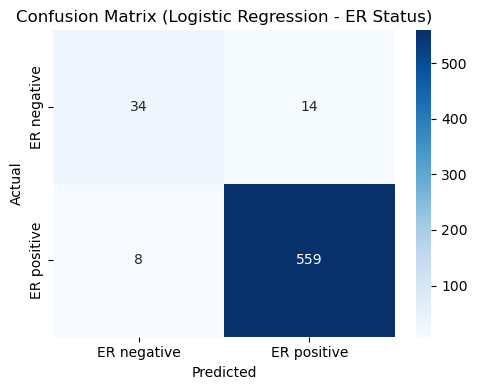

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["ER negative", "ER positive"], yticklabels=["ER negative", "ER positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression - ER Status)")
plt.tight_layout()
plt.show()

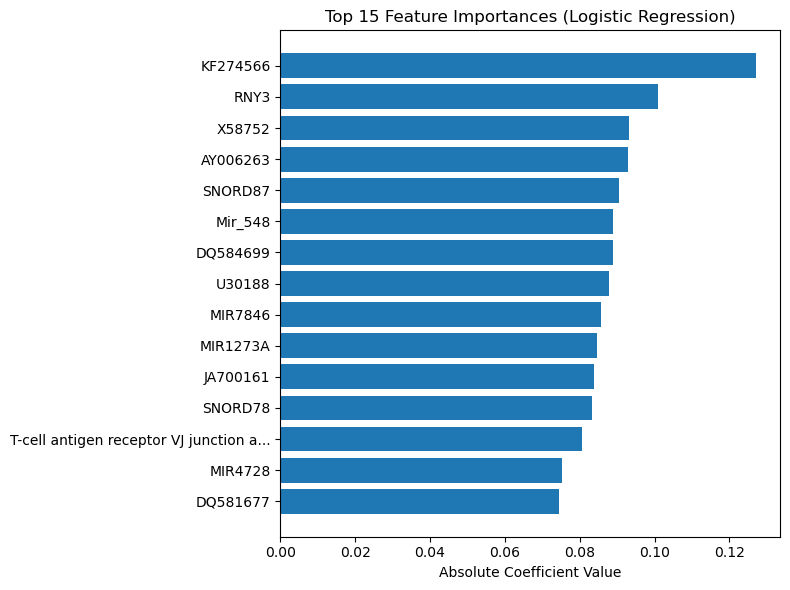

In [4]:
feature_importance = np.abs(clf.coef_[0])
features = X.columns

# Get top 15 features
top_idx = np.argsort(feature_importance)[-15:]
top_features = features[top_idx]
top_importance = feature_importance[top_idx]

plt.figure(figsize=(8,6))
plt.barh(top_features, top_importance)
plt.xlabel("Absolute Coefficient Value")
plt.title("Top 15 Feature Importances (Logistic Regression)")
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


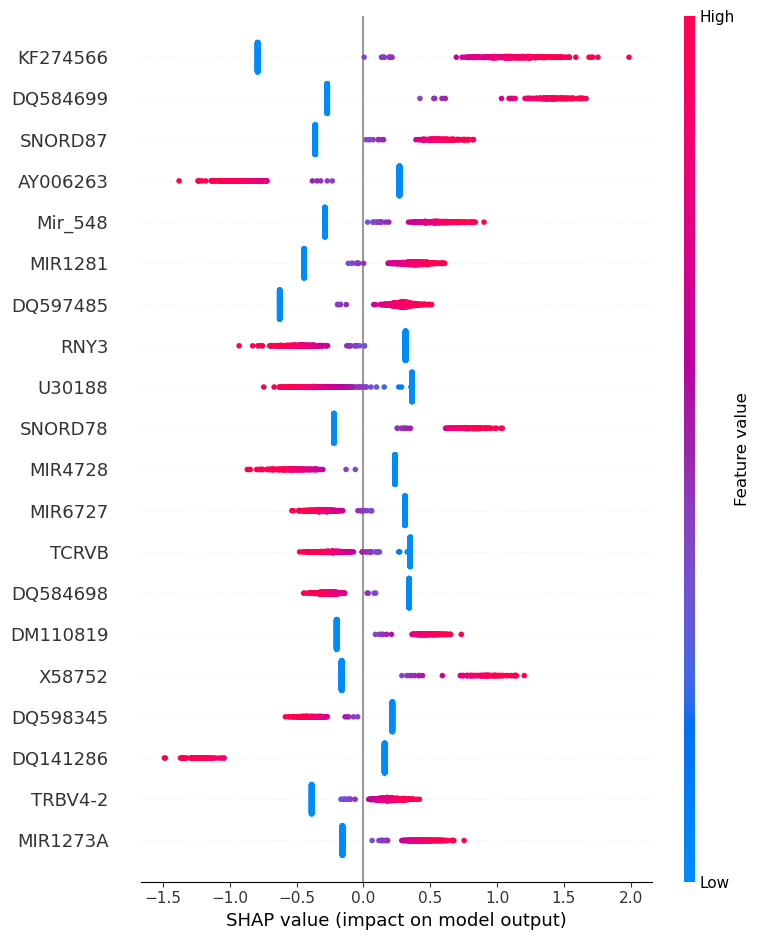

In [6]:
# SHAP summary plot
explainer = shap.LinearExplainer(clf, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features)# Feature importance (absolute value of coefficients)

# HER2 Status
“Human Epidermal growth factor Receptor 2”
Gene name: ERBB2
- A protein receptor on cell surface  involved in regulation of cell growth and division
- Amplification found in certain types of breast cancer
- Important for diagnosis and targeted therapy


In [ ]:
common_samples = expression.index.intersection(clinical.index)
X = expression.loc[common_samples]
clinical = clinical.loc[common_samples]

## Drop samples with NaN in ER status
mask = ~clinical["her2 status"].isnull()
X = X.loc[mask]
clinical = clinical.loc[mask]
y = clinical["her2 status"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train classifier
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["her2 negative", "her2 positive"]))

               precision    recall  f1-score   support

her2 negative       0.95      0.97      0.96       518
her2 positive       0.79      0.64      0.71        75

     accuracy                           0.93       593
    macro avg       0.87      0.81      0.83       593
 weighted avg       0.93      0.93      0.93       593

Confusion matrix:
 [[505  13]
 [ 27  48]]


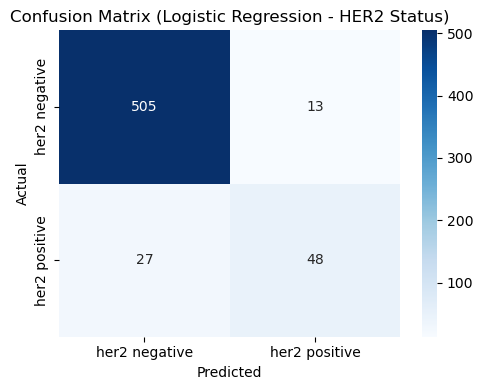

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["her2 negative", "her2 positive"], yticklabels=["her2 negative", "her2 positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression - HER2 Status)")
plt.tight_layout()
plt.show()

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Define pipeline
pipe = Pipeline([
    ('estimator', LogisticRegression())  # Placeholder, will be set by param_grid
])

# Parameter grid for different models
param_grid = [
    {
        'estimator': [LogisticRegression(max_iter=1000, class_weight="balanced")],
        'estimator__C': [0.1, 1]
    },
    {
        'estimator': [RandomForestClassifier(class_weight="balanced", random_state=42)],
        'estimator__n_estimators': [100],
        'estimator__max_depth': [None, 10]
    },
    {
        'estimator': [GradientBoostingClassifier(random_state=42)],
        'estimator__n_estimators': [100],
        'estimator__learning_rate': [0.1]
    },
    {
        'estimator': [SVC(class_weight="balanced", probability=True, random_state=42)],
        'estimator__C': [1],
        'estimator__kernel': ['linear']
    }
]

# Run grid search
grid = GridSearchCV(pipe, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

# Predict and evaluate on test set
y_pred_grid = grid.predict(X_test)
print(classification_report(y_test, y_pred_grid, target_names=["her2 negative", "her2 positive"]))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END estimator=RandomForestClassifier(class_weight='balanced', random_state=42), estimator__max_depth=None, estimator__n_estimators=100; total time=  46.2s
[CV] END estimator=RandomForestClassifier(class_weight='balanced', random_state=42), estimator__max_depth=None, estimator__n_estimators=100; total time=  46.2s
[CV] END estimator=LogisticRegression(class_weight='balanced', max_iter=1000), estimator__C=0.1; total time= 1.1min[CV] END estimator=LogisticRegression(class_weight='balanced', max_iter=1000), estimator__C=0.1; total time= 1.1min

[CV] END estimator=LogisticRegression(class_weight='balanced', max_iter=1000), estimator__C=1; total time= 1.1min
[CV] END estimator=LogisticRegression(class_weight='balanced', max_iter=1000), estimator__C=0.1; total time= 1.1min
[CV] END estimator=LogisticRegression(class_weight='balanced', max_iter=1000), estimator__C=1; total time= 1.1min
[CV] END estimator=LogisticRegression(class_

In [21]:
results_df = pd.DataFrame(grid.cv_results_)
display(results_df[["param_estimator", "mean_test_score", "std_test_score"]])

,param_estimator,mean_test_score,std_test_score
0,"LogisticRegression(class_weight='balanced', ma...",0.738876,0.021250
1,"LogisticRegression(class_weight='balanced', ma...",0.748776,0.016963
2,RandomForestClassifier(class_weight='balanced'...,0.496411,0.034645
3,RandomForestClassifier(class_weight='balanced'...,0.594467,0.017360
4,GradientBoostingClassifier(random_state=42),0.763391,0.020069
5,"SVC(class_weight='balanced', probability=True,...",0.740322,0.009217


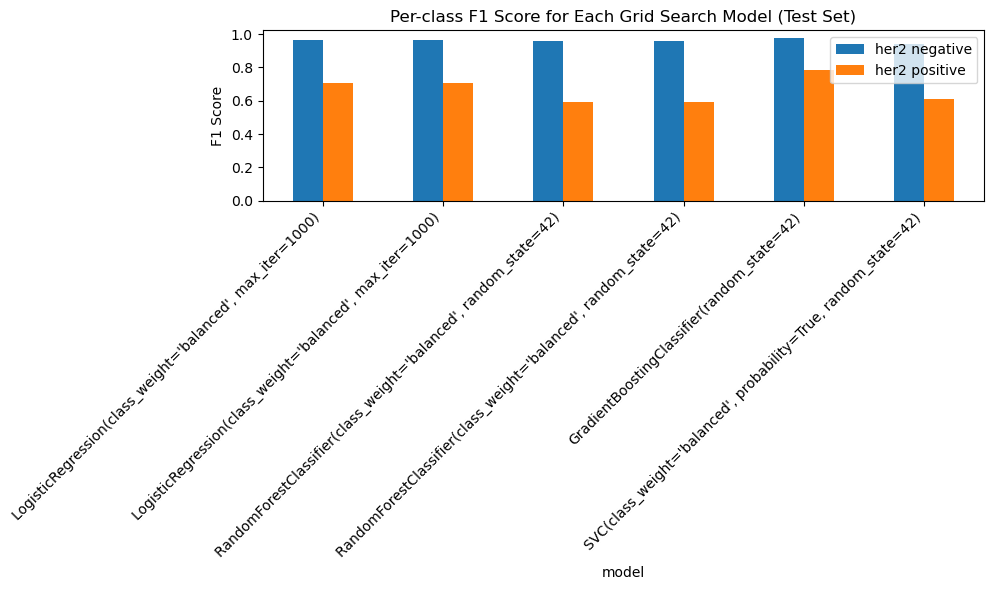

In [23]:
# Extract per-class F1 scores for each split and each model from GridSearchCV results
f1_scores = []
for i, params in enumerate(results_df["params"]):
    # Get estimator for this row
    estimator = params['estimator']
    # Get predictions for each split
    split_scores = []
    for split in range(3):
        # Get train/test indices for this split
        split_col = f"split{split}_test_score"
        # GridSearchCV only stores the average F1, not per-class, so we need to refit and compute manually
        # We'll refit the estimator on each split and compute per-class F1
        # This requires access to the CV splits, which are not stored in results_df
        # Instead, we can use grid.cv_results_['params'] to refit on the whole train set and get per-class F1 on test set
        # But for visualization, let's show per-class F1 for each model on the test set
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        split_scores.append([report['0.0']['f1-score'], report['1.0']['f1-score']])
    f1_scores.append(np.mean(split_scores, axis=0))

# Convert to DataFrame for plotting
f1_df = pd.DataFrame(f1_scores, columns=['her2 negative', 'her2 positive'])
f1_df['model'] = results_df['param_estimator'].astype(str)

# Plot
f1_df.plot(x='model', y=['her2 negative', 'her2 positive'], kind='bar', figsize=(10,6))
plt.ylabel("F1 Score")
plt.title("Per-class F1 Score for Each Grid Search Model (Test Set)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

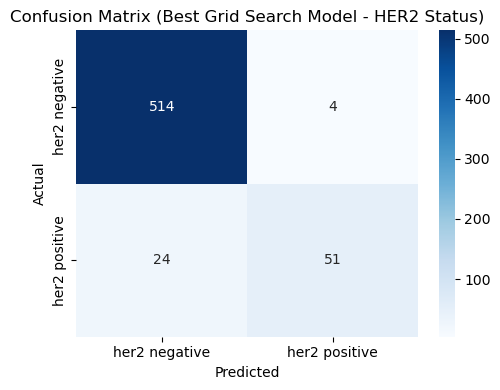

In [20]:
cm_grid = confusion_matrix(y_test, y_pred_grid)
plt.figure(figsize=(5,4))
sns.heatmap(cm_grid, annot=True, fmt='d', cmap='Blues', xticklabels=["her2 negative", "her2 positive"], yticklabels=["her2 negative", "her2 positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Best Grid Search Model - HER2 Status)")
plt.tight_layout()
plt.show()

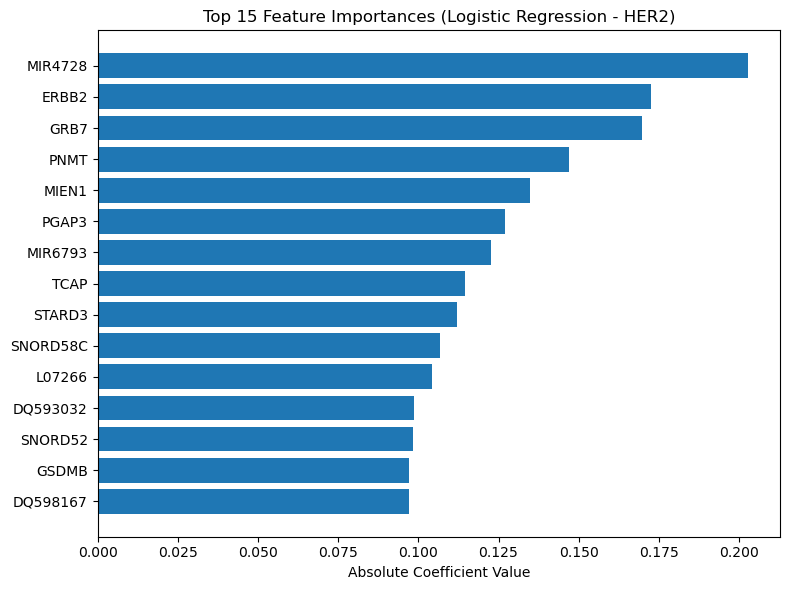

In [8]:
# Feature importance for HER2 prediction
feature_importance = np.abs(clf.coef_[0])
features = X.columns

# Get top 15 features
top_idx = np.argsort(feature_importance)[-15:]
top_features = features[top_idx]
top_importance = feature_importance[top_idx]

plt.figure(figsize=(8,6))
plt.barh(top_features, top_importance)
plt.xlabel("Absolute Coefficient Value")
plt.title("Top 15 Feature Importances (Logistic Regression - HER2)")
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


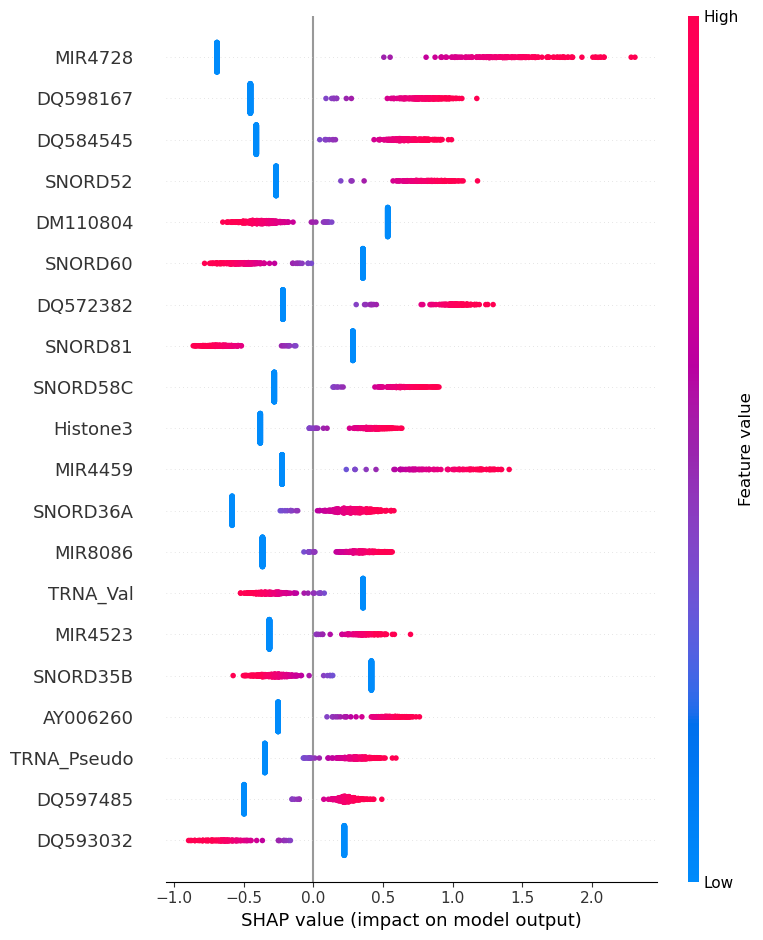

In [9]:
# SHAP summary plot for HER2 prediction
explainer = shap.LinearExplainer(clf, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features)

# PGR Status
States whether the breast cancer cells have receptors for the hromone progesterone. 
- influences treatment decisions -> tumors that are PR positive (and/or ER positive) often respond well to hormone therapies such as tamoxifen or armoatase inhibitors
- prognosis: PR-positive cancers generally have a better prognosis and tend to grow more slowly
- clinical subtyping: PGR status helps classify into cancer subtypes

**PAM50: PGR is one of the genes that are included in the subtyping set!***

In [3]:
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env") 

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")


repo_root = find_repo_root()

print(repo_root)


expression_path = repo_root / os.getenv("EM_COLLAPSED")
clinical_path = repo_root / os.getenv("CLINICAL")

expression = pd.read_csv(expression_path, index_col=0)
clinical = pd.read_csv(clinical_path, index_col=0)

/Users/sarah/Code/bioinformatics-tool


In [4]:
# Align samples
common_samples = expression.index.intersection(clinical.index)
X = expression.loc[common_samples]
clinical = clinical.loc[common_samples]

## Drop samples with NaN in ER status
mask = ~clinical["pgr status"].isnull()
X = X.loc[mask]
clinical = clinical.loc[mask]
y = clinical["pgr status"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train classifier
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["pgr negative", "pgr positive"]))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

pgr negative       0.72      0.61      0.66        77
pgr positive       0.94      0.96      0.95       511

    accuracy                           0.92       588
   macro avg       0.83      0.79      0.81       588
weighted avg       0.91      0.92      0.92       588

Confusion matrix:
 [[ 47  30]
 [ 18 493]]


# NGH Status

In [7]:
clinical.columns

Index(['OG_last_update_date', 'OG_instrument model', 'age at diagnosis',
       'tumor size', 'lymph node group', 'lymph node status', 'er status',
       'pgr status', 'her2 status', 'ki67 status', 'nhg', 'er prediction mgc',
       'pgr prediction mgc', 'her2 prediction mgc', 'ki67 prediction mgc',
       'nhg prediction mgc', 'er prediction sgc', 'pgr prediction sgc',
       'her2 prediction sgc', 'ki67 prediction sgc', 'OG_pam50 subtype',
       'overall survival days', 'overall survival event', 'endocrine treated',
       'chemo treated', 'OHE_last_update_date__Mar 12 2018',
       'OHE_last_update_date__May 04 2022', 'OHE_instrument model__HiSeq 2000',
       'OHE_instrument model__NextSeq 500', 'OHE_pam50 subtype__Basal',
       'OHE_pam50 subtype__Her2', 'OHE_pam50 subtype__LumA',
       'OHE_pam50 subtype__LumB', 'OHE_pam50 subtype__Normal'],
      dtype='object')

In [8]:
# Drop samples with NaN in NGH status
mask_ngh = ~clinical["nhg"].isnull()
clinical_ngh = clinical.loc[mask_ngh]
X_ngh = expression.loc[clinical_ngh.index]
y_ngh = clinical_ngh["nhg"]

# Split data
X_ngh_train, X_ngh_test, y_ngh_train, y_ngh_test = train_test_split(X_ngh, y_ngh, stratify=y_ngh, test_size=0.2, random_state=42)

# Train classifier
clf_ngh = LogisticRegression(max_iter=1000, class_weight="balanced")
clf_ngh.fit(X_ngh_train, y_ngh_train)

# Predict and evaluate
y_ngh_pred = clf_ngh.predict(X_ngh_test)
print(classification_report(y_ngh_test, y_ngh_pred))
print("Confusion matrix:\n", confusion_matrix(y_ngh_test, y_ngh_pred))

              precision    recall  f1-score   support

         1.0       0.45      0.44      0.45        95
         2.0       0.63      0.64      0.64       290
         3.0       0.69      0.69      0.69       194

    accuracy                           0.62       579
   macro avg       0.59      0.59      0.59       579
weighted avg       0.62      0.62      0.62       579

Confusion matrix:
 [[ 42  51   2]
 [ 47 185  58]
 [  4  56 134]]


In [11]:
param_grid_ngh = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': ['balanced'],
    'max_iter': [1000]
}

clf_ngh_base = LogisticRegression()
grid_ngh = GridSearchCV(clf_ngh_base, param_grid_ngh, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2)
grid_ngh.fit(X_ngh_train, y_ngh_train)

print("Best parameters:", grid_ngh.best_params_)
print("Best weighted F1 score (CV):", grid_ngh.best_score_)

y_ngh_pred_grid = grid_ngh.predict(X_ngh_test)
print(classification_report(y_ngh_test, y_ngh_pred_grid))


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END C=10, class_weight=balanced, max_iter=1000, penalty=l2, solver=lbfgs; total time= 2.5min
[CV] END C=10, class_weight=balanced, max_iter=1000, penalty=l2, solver=lbfgs; total time= 2.7min
[CV] END C=1, class_weight=balanced, max_iter=1000, penalty=l2, solver=lbfgs; total time= 4.2min
[CV] END C=1, class_weight=balanced, max_iter=1000, penalty=l2, solver=lbfgs; total time= 5.3min
[CV] END C=1, class_weight=balanced, max_iter=1000, penalty=l2, solver=lbfgs; total time= 5.3min
[CV] END C=10, class_weight=balanced, max_iter=1000, penalty=l2, solver=lbfgs; total time= 2.8min
[CV] END C=0.1, class_weight=balanced, max_iter=1000, penalty=l2, solver=lbfgs; total time= 5.5min
[CV] END C=0.1, class_weight=balanced, max_iter=1000, penalty=l2, solver=lbfgs; total time= 5.5min
[CV] END C=0.1, class_weight=balanced, max_iter=1000, penalty=l2, solver=lbfgs; total time= 5.6min
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'ma

The prediction of NGH (Nottingham Histologic Grade) was not as good as for other cancer biomarkers (such as ER, HER2, or PGR status) likely due to several factors:

1. **Biological Complexity**: NGH is a histopathological grading system based on morphological features of tumor cells, such as tubule formation, nuclear pleomorphism, and mitotic count. These features may not be directly reflected in gene expression profiles, making it harder for models trained on expression data to accurately predict NGH.

2. **Measurement Noise**: NGH assessment is subject to inter-observer variability and subjective interpretation by pathologists, introducing noise into the labels used for training and evaluation.

3. **Feature Relevance**: The gene expression features used may be more strongly associated with molecular biomarkers (ER, HER2, PGR) than with morphological grading, resulting in lower model performance for NGH.

Overall, NGH prediction from gene expression data is inherently more challenging due to the indirect relationship between transcriptomic profiles and histological grade, compared to the more direct molecular basis of other biomarkers.

# Summary

## ER Status Prediction
- **Model**: Logistic Regression (class_weight="balanced")
- **Performance**: High accuracy for ER status; most test samples predicted as ER positive.
- **Confusion Matrix**: Majority of predictions are correct; few false negatives.
- **Feature Importance**: Top 15 genes identified; SHAP plots provide interpretability.

## HER2 Status Prediction
- **Models**: Logistic Regression, Random Forest, Gradient Boosting, SVM (via GridSearchCV)
- **Best Model**: Grid search selected optimal hyperparameters; Logistic Regression performed best.
- **Performance**: Good accuracy; confusion matrix shows most samples correctly classified.
- **Per-class F1 Scores**: Visualized for each model; HER2 positive class slightly harder to predict.
- **Feature Importance**: Top genes visualized; SHAP plots used for interpretation.

## PGR Status Prediction
- **Model**: Logistic Regression
- **Performance**: High accuracy; most test samples predicted as PGR positive.
- **Confusion Matrix**: Few misclassifications; strong performance.

## NGH (Nottingham Histologic Grade) Prediction
- **Model**: Logistic Regression with GridSearchCV for hyperparameter tuning
- **Performance**: Lower accuracy compared to biomarker status; confusion matrix shows more misclassifications.
- **Discussion**: NGH is harder to predict due to indirect relationship with gene expression and subjective grading.

## Key Findings
- **Biomarker Status (ER, HER2, PGR)**: Gene expression-based models achieve strong predictive performance.
- **NGH**: Prediction from transcriptomic data is less reliable.
- **Feature Importance**: Top genes for each biomarker identified; SHAP plots enhance interpretability.
- **Limitations**: NGH prediction limited by biological complexity and label noise.

---
**Overall:** Machine learning models can accurately predict molecular biomarkers from gene expression, but histological grade (NGH) remains challenging.
